In [1]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import optuna
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# 解决中文乱码问题
plt.rcParams["font.sans-serif"]=["SimHei"] 
plt.rcParams["axes.unicode_minus"]=False 

In [2]:
data=pd.read_csv('./try.csv')
train_data,test_data=train_test_split(data,test_size=0.2, random_state=1318)
feature=train_data.drop(['Ea','Unnamed: 0'],axis=1)
label=train_data['Ea']
x_test=test_data.drop(['Ea','Unnamed: 0'],axis=1)
y_test=test_data['Ea']

In [3]:
kfold = KFold(n_splits = 5, random_state = 1314, shuffle = True)

In [4]:
def optuna_objective(trial):
    alpha=trial.suggest_float('alpha',0.001,1)
    reg=Ridge(alpha=alpha)
    loss=cross_val_score(reg,feature,label,cv=kfold,error_score='raise')
    return pow(abs(loss.mean()),0.5)

In [5]:
def optimizer_optuna(n_trials):
    algo=optuna.samplers.TPESampler(n_startup_trials=10,n_ei_candidates=24)
    study=optuna.create_study(sampler=algo,direction="maximize")
    study.optimize(optuna_objective,n_trials=n_trials,show_progress_bar=True)
    print("\n","\n","best params: ", study.best_trial.params,
          "\n","\n","best score: ", study.best_trial.values,
          "\n")
    
    return study.best_trial.params, study.best_trial.values

In [6]:
optimizer_optuna(100)

[I 2023-05-05 18:09:20,387] A new study created in memory with name: no-name-2e2b8a6a-c4c1-47f4-9edc-a0116780c72e
Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-05-05 18:09:20,444] Trial 0 finished with value: 0.7965739831117012 and parameters: {'alpha': 0.044222743424143146}. Best is trial 0 with value: 0.7965739831117012.
[I 2023-05-05 18:09:20,484] Trial 1 finished with value: 0.8047057244202717 and parameters: {'alpha': 0.4726366947223924}. Best is trial 1 with value: 0.8047057244202717.
[I 2023-05-05 18:09:20,589] Trial 2 finished with value: 0.8056232836088772 and parameters: {'alpha': 0.6839184078225964}. Best is trial 2 with value: 0.8056232836088772.
[I 2023-05-05 18:09:20,630] Trial 3 finished with value: 0.8058320939883582 and parameters: {'alpha': 0.9357041983674036}. Best is trial 3 with value: 0.8058320939883582.
[I 2023-05-05 18:09:20,670] Trial 4 finished with value: 0.8053423124093604 and parameters: {'alpha': 0.594658108831131}. Best is trial 3 with value: 0.8058320939883582.
[I 2023-05-05 18:09:20,709] Trial 5 finished with value: 0.8057184217648619 and parameters: {'alpha': 0.7294304307616775}. Best is trial 3 with 

({'alpha': 0.8815865211763871}, [0.8058460554317793])

In [39]:
model = Ridge(alpha=0.2).fit(X=feature , y=label)
r2_score = cross_val_score(model, feature, label, cv=kfold, scoring='r2').mean()
rmse_score = pow(abs(cross_val_score(model, feature, label, cv=kfold, scoring='neg_mean_squared_error').mean()),0.5)
print('r2:',r2_score)
print('rmse:',rmse_score)

r2: 0.6423436613409297
rmse: 0.21045675585650658


In [40]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
print('r2:',r2_score(label,model.predict(feature)))
print('MAE:',mean_absolute_error(label,model.predict(feature)))
print('测试集得分为：', r2_score(y_test,model.predict(x_test)),mean_absolute_error(y_test,model.predict(x_test)))

r2: 0.769066605589926
MAE: 0.14137137649123227
测试集得分为： 0.7024084881263809 0.1593682270458817


In [32]:
# 预测1
Y1=model.predict(test_data.drop(['Ea','Unnamed: 0'],axis=1))
Y2=test_data['Ea']
d={'Y_pred':Y1,
   'Y_True':Y2
   }
pred_show=pd.DataFrame(d)

In [33]:
# 预测2
Y_1=model.predict(feature)
Y_2=label
d_1={'Y_pred':Y_1,
   'Y_True':Y_2
   }
pred_show_1=pd.DataFrame(d_1)

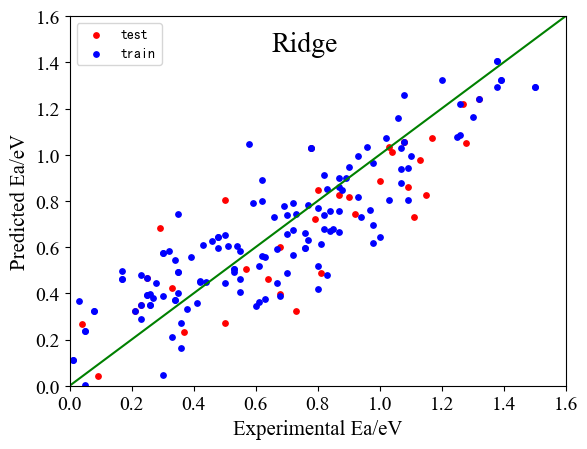

In [41]:
plt.scatter(pred_show.iloc[:,1],pred_show.iloc[:,0],color='r',s=15,label='test')
plt.scatter(pred_show_1.iloc[:,1],pred_show_1.iloc[:,0],color='b',s=15,label='train')
plt.xlim((0,1.6))
plt.xlabel('Experimental Ea/eV',fontsize=15,font=Path('..\TimesNewRoman.ttf'))
plt.xticks(fontsize=14,fontname='Times New Roman')
plt.ylim((0,1.6))
plt.ylabel('Predicted Ea/eV',fontsize=15,font=Path('..\TimesNewRoman.ttf'))
plt.yticks(fontsize=14,fontname='Times New Roman')
plt.plot([0,1.6],[0,1.6],color='g')
plt.text(0.65,1.45,'Ridge',fontsize=20,font=Path('..\TimesNewRoman.ttf'))
plt.legend()
plt.show()